# NLP classifier

In [ ]:
import pandas as pd
from pathlib import Path
import re
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer

import numpy as np 
import joblib
import matplotlib.pyplot as plt

In [14]:
# config
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / "data"
MODEL_DIR = BASE_DIR / "models"

df = pd.read_parquet(DATA_DIR / "preprocessed_transactions.parquet")
# sampling 100k transactions from 4.5 million transactions
df2, _ = train_test_split(
    df,
    train_size=100_000,
    stratify=df['category'],
    random_state=42
)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 2715467 to 350123
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   description  100000 non-null  object
 1   category     100000 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [15]:
df2.category.value_counts()

category
Utilities & Services          10039
Government & Legal            10022
Financial Services            10019
Income                        10010
Charity & Donations           10001
Shopping & Retail              9996
Healthcare & Medical           9994
Entertainment & Recreation     9986
Transportation                 9981
Food & Dining                  9952
Name: count, dtype: int64

## Vecotrization (BERT) and Pipeline 

In [16]:
# preprocessing function for pipeline
stop_words_en = set(stopwords.words('english'))
stop_words_fr = set(stopwords.words('french'))
stop_words = stop_words_en.union(stop_words_fr)

lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = str(text).lower() # lowercasing everything
    text = re.sub(r'#(\w+)', r'\1', text) # hashtag removal but keeping the text
    text = re.sub(r'\d+', '', text) # number removal
    text = re.sub(r'[^a-z\s]', '', text) # removes anything other than alpha
    text = re.sub(r'(.)\1{2,}', r'\1\1', text) # standardizing words
    text = re.sub(r'\s+', ' ', text).strip() # substitutes any >1 space with single space

    tokens = word_tokenize(text) # tokenization
    tokens = [word for word in tokens if word not in stop_words] # stop word removal
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

In [17]:
# Preprocessor class for pipeline
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, func):
        self.func = func
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [self.func(x) for x in X]


In [18]:
# BERT Vectorizer class for pipeline
class BertVectorizer(TransformerMixin):
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model = SentenceTransformer(model_name)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self.model.encode(X)

In [19]:
# Logistic Regression Pipeline
lr_pipeline = Pipeline([
    ('preprocessor', Preprocessor(preprocess)),
    ('embeddings', BertVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000))
])

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


## Model Training and Eval

### Train-test split

In [20]:
X = df2['description'].values
y = df2['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=df2['category'],
                                                    random_state=42)

### 1. Logistic Regression

In [21]:
# training the classifier
lr_pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('embeddings', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,func,<function pre...t 0x13b937420>
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stoppi

In [22]:
# predictions
y_pred = lr_pipeline.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

                            precision    recall  f1-score   support

       Charity & Donations       1.00      1.00      1.00      2000
Entertainment & Recreation       1.00      0.99      0.99      1997
        Financial Services       0.99      1.00      0.99      2004
             Food & Dining       0.99      0.98      0.99      1991
        Government & Legal       0.97      0.98      0.97      2004
      Healthcare & Medical       0.96      0.97      0.97      1999
                    Income       0.98      0.99      0.99      2002
         Shopping & Retail       0.94      0.94      0.94      1999
            Transportation       0.98      0.97      0.98      1996
      Utilities & Services       0.98      0.98      0.98      2008

                  accuracy                           0.98     20000
                 macro avg       0.98      0.98      0.98     20000
              weighted avg       0.98      0.98      0.98     20000

Accuracy: 0.97955


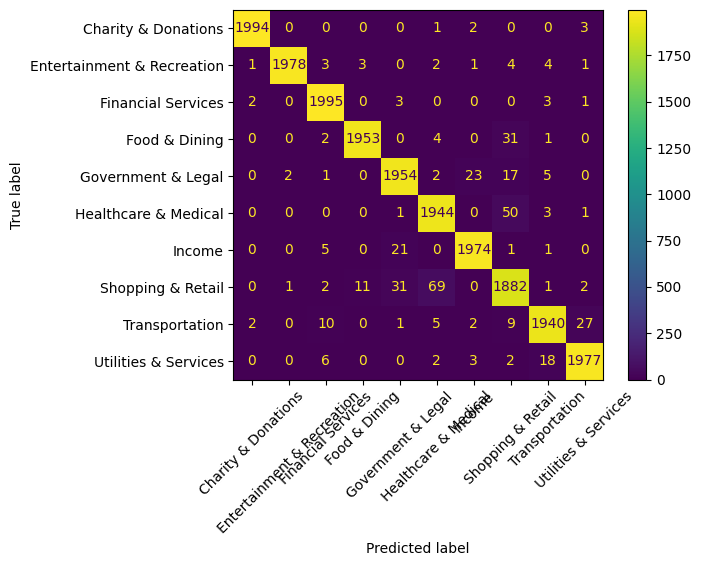

In [23]:
ConfusionMatrixDisplay.from_estimator(lr_pipeline, X_test, y_test, xticks_rotation=45)
plt.show()

Since Logistic Regression has strong results, skipping exploring other models.

In [24]:
# Saving the model
joblib.dump(lr_pipeline, MODEL_DIR / 'logistic_bert_classifier.pkl')

['/Users/june/Desktop/vidhi/spending_tracker/models/logistic_bert_classifier.pkl']